In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
import ccdproc as ccdp

import numpy as np
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

In [2]:
def get_data_and_headers(*args):
    all_data = list()
    all_headers = list()
    for path in args:
        files = ccdp.ImageFileCollection(path)
        night_data = [i for i in files.data()]
        night_headers = [i for i in files.headers()]
        all_data.extend(night_data)
        all_headers.extend(night_headers)
    return all_data, all_headers

In [3]:
filter = 'Luminance'
# Blue up to 86
# Red up to 86
# Green up to 86
# Luminance up to 174

night_1 = '../reduced-lights_2022_12_06/' + filter

data, headers = get_data_and_headers(night_1)
data, headers = data[:174], headers[:174]

In [4]:
len(data)

174

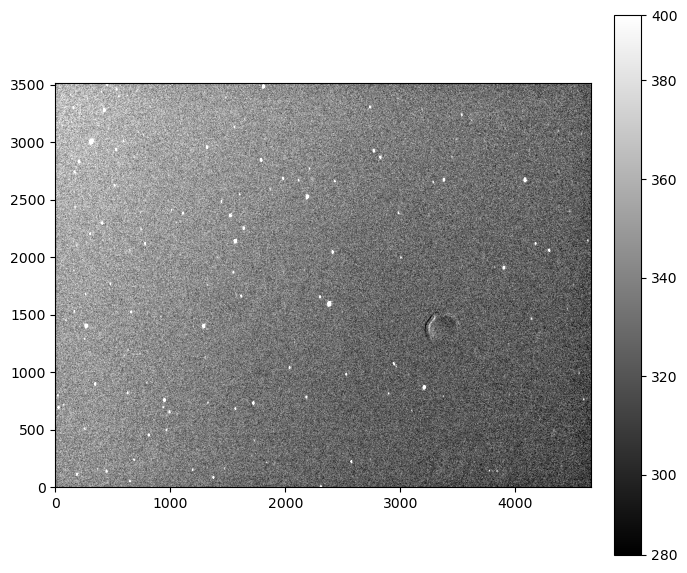

In [5]:
from convenience_functions import show_image

show_image(data[-1], cmap = 'gray')

In [6]:
import pandas as pd

def find_sources(array):
    mean, median, std = sigma_clipped_stats(array, sigma=2.5)
    daofind = DAOStarFinder(fwhm=9.0, threshold=5.*std)
    sources = daofind(array - median)
    return sources

def image_trimmer(sources, array):
    local_df = sources.to_pandas()
    image_size = array.shape
    x_trim = image_size[1] * 0.05
    y_trim = image_size[0] * 0.05
    local_df = local_df[(local_df['xcentroid'] - x_trim > 0) & (local_df['xcentroid'] + x_trim < image_size[1])]
    local_df = local_df[(local_df['ycentroid'] - y_trim > 0) & (local_df['ycentroid'] + y_trim < image_size[0])]
    return local_df.reset_index(drop = True).drop('id', axis = 'columns')

def excluding_duplicates(df, fwhm):
    #Taking initial comparison values from first row
    xcenter, ycenter, flux = df.iloc[0][['xcentroid', 'ycentroid', 'flux']]
    last_index = 0
    #Including first row in result
    filters = [True]

    #Skipping first row in comparisons
    for index, row in df.iloc[1:].iterrows():
        if (xcenter - 4*fwhm <= row['xcentroid'] <= 4*fwhm + xcenter) or (ycenter - 4*fwhm <= row[
            'ycentroid'] <= 4*fwhm + ycenter):
            # Once we have the two that are very close to each other we want to keep the one with the highest flux
            if df.iloc[last_index]['flux'] > row['flux']:
                filters.append(False)
            else:
                filters[last_index] = False
                filters.append(True)
                xcenter = row['xcentroid']
                ycenter = row['ycentroid']
                last_index = index
        else:
            filters.append(True)
            # Updating values to compare based on latest accepted row
            xcenter = row['xcentroid']
            ycenter = row['ycentroid']
            last_index = index
    result = df.loc[filters]
    return result.reset_index(drop=True)

def find_nearest(sources_1, sources_2, max_dist):
    positions = np.transpose((sources_1['xcentroid'], sources_1['ycentroid']))
    positions_2 = np.transpose((sources_2['xcentroid'], sources_2['ycentroid']))
    mapping_dict = dict()
    for index, value in enumerate(positions):
        difference = np.subtract(positions_2, value)
        squared_difference = np.square(difference)
        min_index = np.sqrt(squared_difference.sum(axis = 1)).argmin()
        if index in mapping_dict:
            old_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][mapping_dict[index]])
            new_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][min_index])
            if old_difference_in_flux > new_difference_in_flux:
                mapping_dict[index] = min_index
        else:
            mapping_dict[index] = min_index
    for key, item in mapping_dict.items():
        x_1, y_1 = sources_1.iloc[key]['xcentroid'], sources_1.iloc[key]['ycentroid']
        x_2, y_2 = sources_2.iloc[item]['xcentroid'], sources_2.iloc[item]['ycentroid']
        distance = np.sqrt((x_1-x_2)**2+(y_1-y_2)**2)
        if distance > max_dist:
            mapping_dict[key] = np.nan
    return mapping_dict


In [7]:
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats, aperture_photometry
from astropy.stats import SigmaClip
import itertools

def signal_to_noise_ratio_v3(image_array, positions_df, r_start, r_end, step_size, delta_r, return_df = False):
    sigclip = SigmaClip(sigma=3, maxiters=5)
    # List of the aperture radius
    aperture_radius = list()

    # List of lists with the signal-to-noise ratios at each aperture
    all_snr_list = list()

    # Empty dataframe for putting everything in later
    snr_df = pd.DataFrame()

    # Get the positions that have a nan in them and ignore them
    nan_indexes = np.argwhere(pd.isnull(positions_df))
    if nan_indexes.size > 0: # Only works with a np.array
        no_nan_positions = list(positions_df[~pd.isnull(positions_df)])
    else: # Only works with a list
        no_nan_positions = list(positions_df)

    for r in np.arange(r_start, r_end + step_size, step_size):

        annulus_aperture = CircularAnnulus(no_nan_positions, r_in = r, r_out = r + delta_r)
        bkg_stats = ApertureStats(image_array, annulus_aperture, sigma_clip=sigclip)
        bkg_median = bkg_stats.median
        apertures = CircularAperture(no_nan_positions, r)
        phot_table = aperture_photometry(image_array, apertures)
        aper_stats = ApertureStats(image_array, apertures, sigma_clip=None)
        aperture_area = aper_stats.sum_aper_area.value
        total_bkg = bkg_median * aperture_area
        phot_bkgsub = phot_table['aperture_sum'] - total_bkg
        signal_to_noise_ratio = list(phot_bkgsub / total_bkg)
        aperture_radius.append(r)
        for nan_index in nan_indexes:
            signal_to_noise_ratio.insert(nan_index[0], np.nan)
        all_snr_list.append(signal_to_noise_ratio)

    # Transpose the snr list
    stars_snr = list(map(list, itertools.zip_longest(*all_snr_list, fillvalue=None)))

    # Add the aperture radii in the first column
    snr_df['Aperture radii'] = aperture_radius

    # Create a column with the snr of each star at different radii
    for star_index, snr_list in enumerate(stars_snr):
        snr_df[f'Star {star_index}'] = snr_list

    indexes_of_max_snr = list(snr_df.idxmax())[1:] # Exclude the first one since it's the aperture radii

    optimal_radii = [snr_df['Aperture radii'].iloc[int(i)] if not np.isnan(i) else np.nan for i in indexes_of_max_snr]
    optimal_radius = np.nanmean(optimal_radii)

    if return_df:
        return snr_df
    else:
        return optimal_radius

In [8]:
def aperture_calculation(image_array, positions_df, r, delta_r, exp_time, gain, return_table = False):
    sigclip = SigmaClip(sigma=3, maxiters=5)
    magnitudes_list = list()
    fluxes_list = list()
    std_magnitudes_list = list()
    for position in positions_df:
        if position is not np.nan:
            annulus_aperture = CircularAnnulus(position, r_in = r, r_out = r + delta_r)
            bkg_stats = ApertureStats(image_array, annulus_aperture, sigma_clip=sigclip)
            bkg_median = bkg_stats.median
            apertures = CircularAperture(position, r)
            phot_table = aperture_photometry(image_array, apertures)
            aper_stats = ApertureStats(image_array, apertures, sigma_clip=None)
            aperture_area = aper_stats.sum_aper_area.value
            total_bkg = bkg_median * aperture_area
            phot_bkgsub = aper_stats.sum - total_bkg
            phot_table['aperture_sum_bkgsub'] = phot_bkgsub
            flux = (gain * phot_bkgsub) / exp_time
            mag = 25 - 2.5 * np.log10(flux)
            std_mag = 1.0857 / np.sqrt(aper_stats.sum)
            magnitudes_list.append(mag)
            fluxes_list.append(flux)
            std_magnitudes_list.append(std_mag)
        else:
            magnitudes_list.append(np.nan)
            fluxes_list.append(np.nan)
            std_magnitudes_list.append(np.nan)
    if return_table:
        return phot_table
    else:
        return magnitudes_list, fluxes_list, std_magnitudes_list

In [9]:
dictionary_list = list()
sources_first_array = find_sources(data[0])
trimmed_sources_first_array = image_trimmer(sources_first_array, data[0])
sources_first_array_no_duplicates = excluding_duplicates(trimmed_sources_first_array, 20)

for index in range(1, len(data)):
    print(index)
    sources_next_array = find_sources(data[index])
    trimmed_sources_next_array = image_trimmer(sources_next_array, data[index])
    sources_next_array_no_duplicates = excluding_duplicates(trimmed_sources_next_array, 20)
    mapping_dictionary = find_nearest(sources_first_array_no_duplicates, sources_next_array_no_duplicates, 170)
    dictionary_list.append(mapping_dictionary)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173


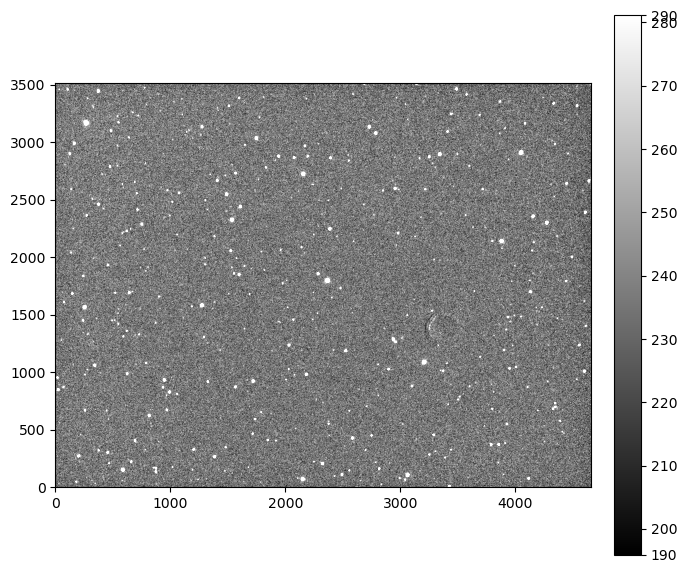

In [10]:
from convenience_functions import show_image

show_image(data[0], cmap = 'gray')

In [11]:
method_2_dict = dict()
method_2_dict[0] = list(dictionary_list[0].keys())
for index, dictionary in enumerate(dictionary_list):
    method_2_dict[index+1] = list(dictionary.values())

In [12]:
method_2_list_sources = list()

for key, item in method_2_dict.items():
    temp_list = list()
    found_sources = find_sources(data[key])
    trimmed_image = image_trimmer(found_sources, data[key])
    final_df = excluding_duplicates(trimmed_image, 20)
    for i in item:
        if i is np.nan:
            temp_list.append(np.nan)
        else:
            # temp_list.append(final_df.iloc[i]['flux'])
            temp_list.append((final_df.iloc[i]['xcentroid'], final_df.iloc[i]['ycentroid']))
    method_2_list_sources.append(temp_list)

In [13]:
all_positions_dict = dict()
for lst in method_2_list_sources:
    for index, item in enumerate(lst):
        if index not in all_positions_dict.keys():
            all_positions_dict[index] = list()
            all_positions_dict[index].append(item)
        else:
            all_positions_dict[index].append(item)

In [14]:
position_df = pd.DataFrame(all_positions_dict)

In [15]:
all_magnitudes = list()
all_fluxes = list()
all_mags_errors = list()
for index in range(len(position_df)):
    print(index)
    positions = np.array(position_df.loc[index])
    loop_array = data[index]
    optimal_aperture_list = signal_to_noise_ratio_v3(loop_array, positions, 1, 30, 0.1, 10)
    magnitudes, fluxes, magnitude_errors = aperture_calculation(loop_array, positions, optimal_aperture_list, 10, 16, 1)
    all_fluxes.append(fluxes)
    all_magnitudes.append(magnitudes)
    all_mags_errors.append(magnitude_errors)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173


In [16]:
all_magnitudes_transposed = list(map(list, itertools.zip_longest(*all_magnitudes, fillvalue=None)))
all_fluxes_transposed = list(map(list, itertools.zip_longest(*all_fluxes, fillvalue=None)))
all_magnitude_error_transposed = list(map(list, itertools.zip_longest(*all_mags_errors, fillvalue = None)))

In [17]:
sources_first_array_no_duplicates

,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,2323.240139,201.963354,0.260858,-0.034189,-0.030724,121,0.0,1450.970901,11.242983,-2.627204
1,458.582787,300.170729,0.391324,-0.127954,0.132908,121,0.0,926.700873,6.863557,-2.091373
2,2584.445012,424.645594,0.394375,-0.018806,0.162204,121,0.0,1645.695822,10.945856,-2.598124
3,818.306123,621.135918,0.566675,-0.128816,0.132093,121,0.0,1745.528561,10.043442,-2.504706
4,4342.823130,727.850633,0.707559,-0.087779,0.010647,121,0.0,325.577268,1.593859,-0.506125
5,994.366668,824.939685,0.489789,0.070247,0.104634,121,0.0,1501.612543,9.564084,-2.451608
6,948.763821,929.239723,0.477809,0.012166,0.180506,121,0.0,2576.943782,16.202662,-3.023966
7,3205.576811,1082.598330,0.397346,0.083327,-0.029817,121,0.0,10146.998769,63.321874,-4.503884
8,2524.672801,1183.579990,0.391809,0.014609,0.197459,121,0.0,1311.469333,8.520610,-2.326177
9,2935.681385,1284.944661,0.257642,-0.131666,-0.150876,121,0.0,840.655798,5.715367,-1.892610


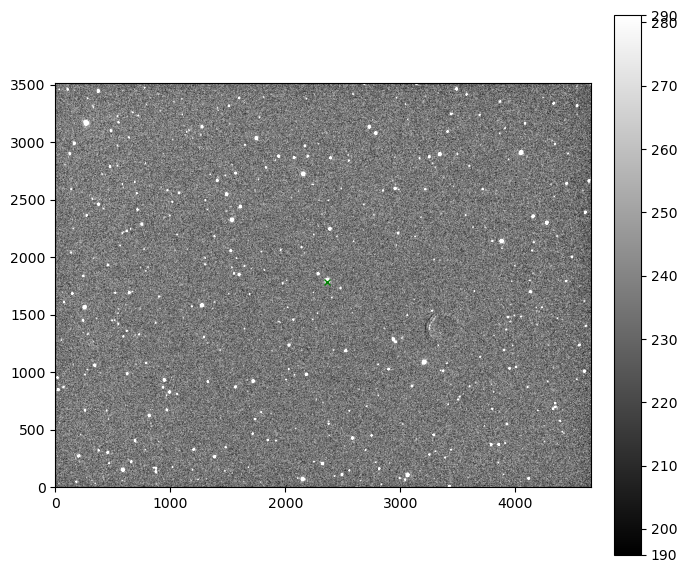

In [18]:
show_image(data[0], cmap = 'gray')
plt.plot(2365, 1783, marker = 'x', markersize = 5, color = 'green')

In [19]:
RZ_Cep_index = 13

RZ_Cep_magnitudes = [all_magnitudes_transposed[RZ_Cep_index]]
RZ_Cep_fluxes = [all_fluxes_transposed[RZ_Cep_index]]
RZ_Cep_mag_error = [all_magnitude_error_transposed[RZ_Cep_index]]

saturated_stars_and_RZ_Cep = [RZ_Cep_index]

In [20]:
stars_index =[i for i in range(len(sources_first_array_no_duplicates)) if i not in saturated_stars_and_RZ_Cep]
magnitude_list_standard_stars = [all_magnitudes_transposed[i] for i in stars_index]
flux_list_standard_stars = [all_fluxes_transposed[i] for i in stars_index]
mag_error_standard_stars = [all_magnitude_error_transposed[i] for i in stars_index]

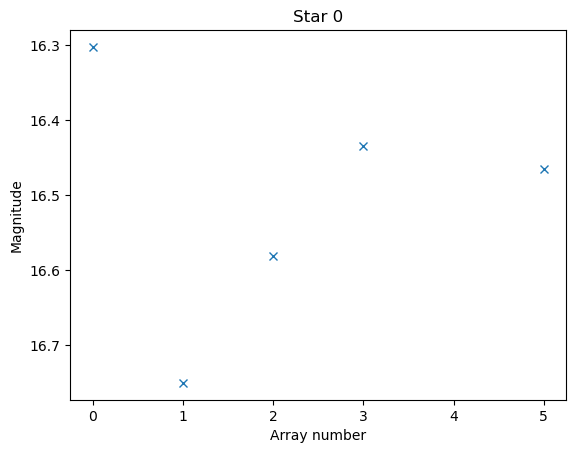

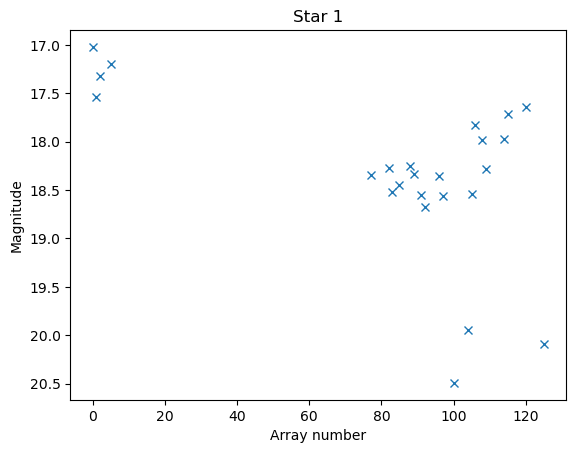

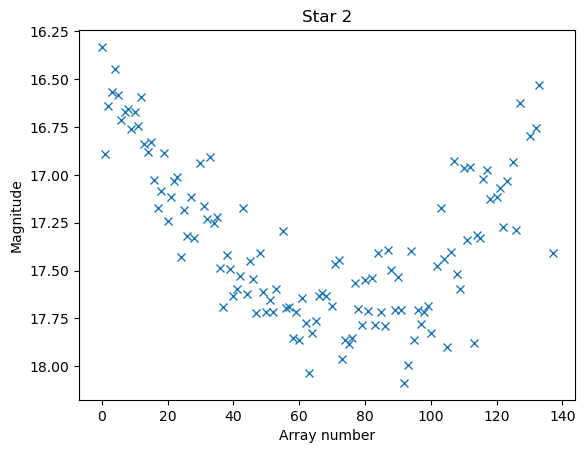

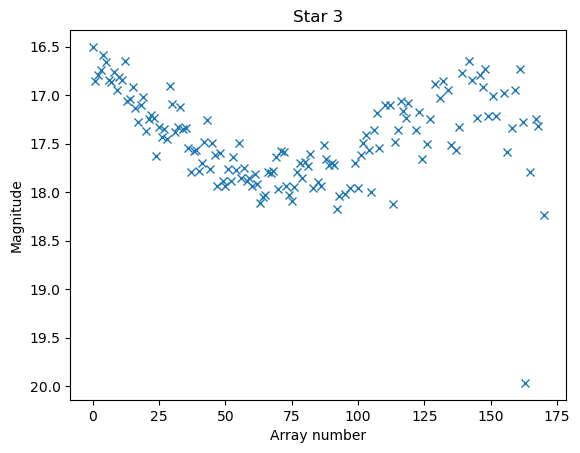

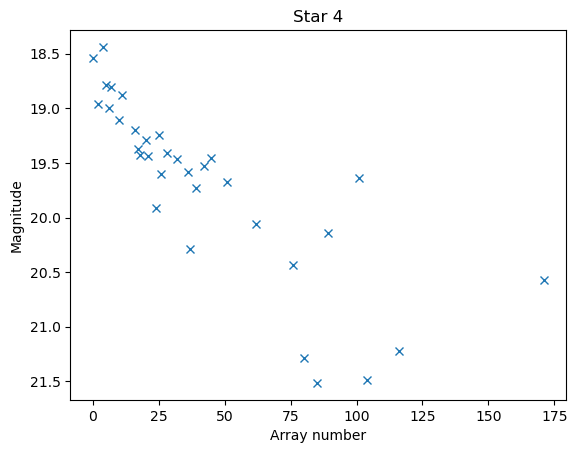

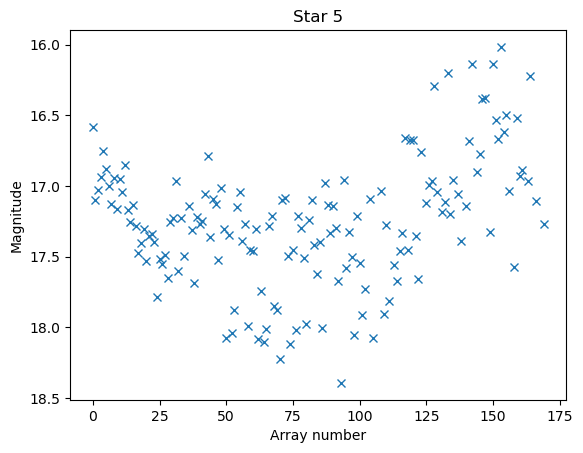

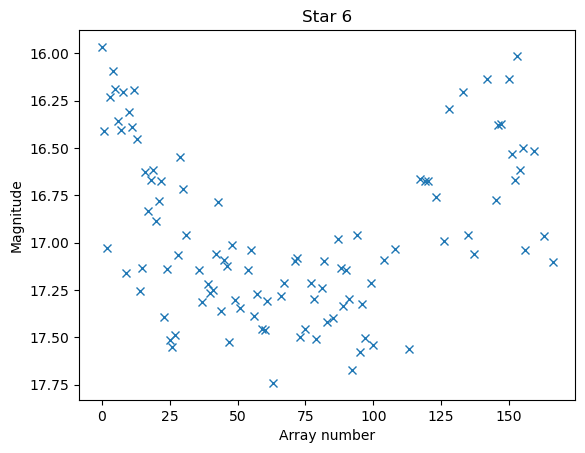

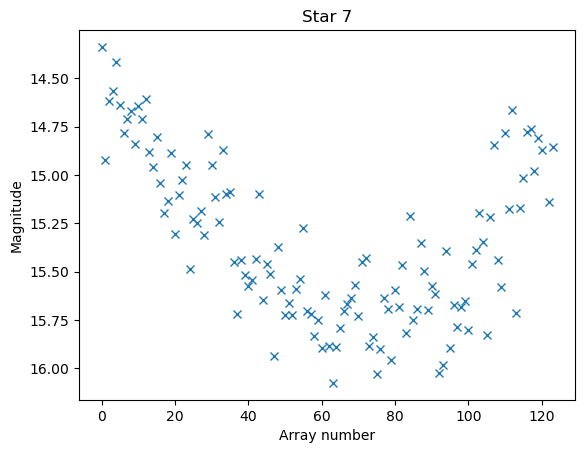

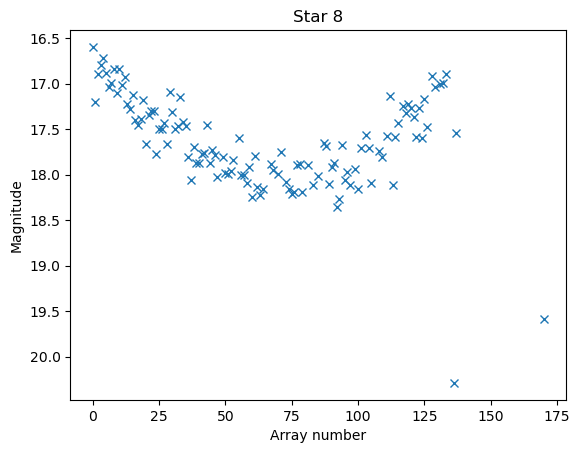

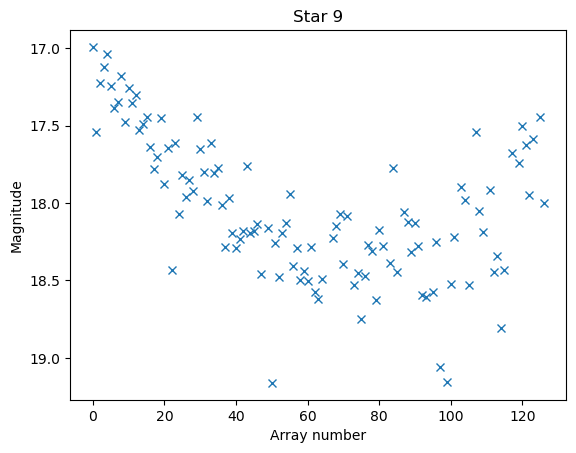

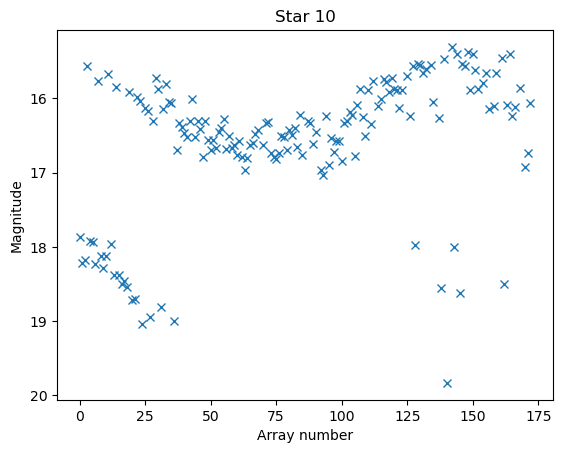

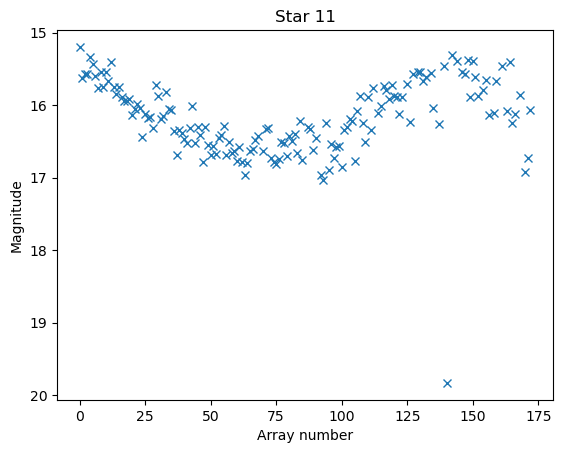

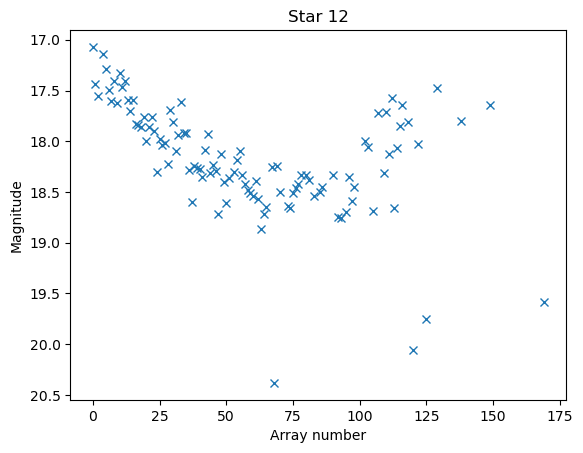

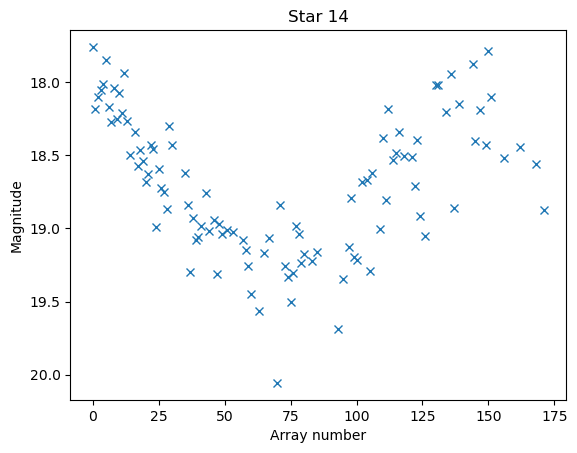

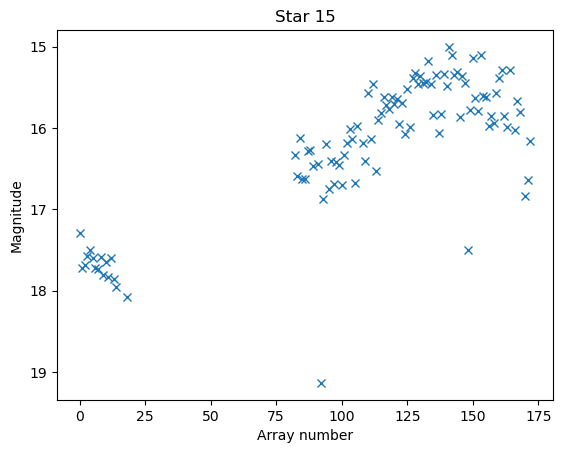

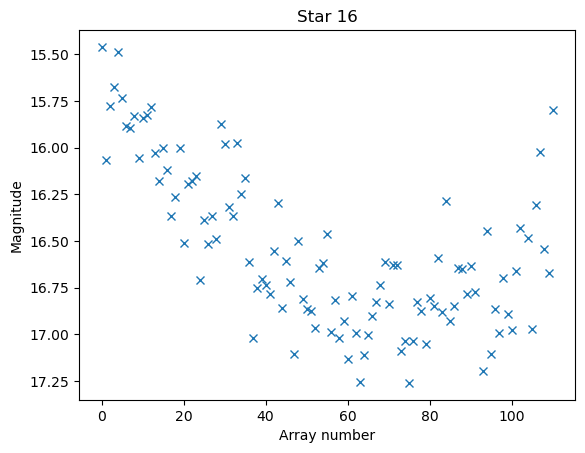

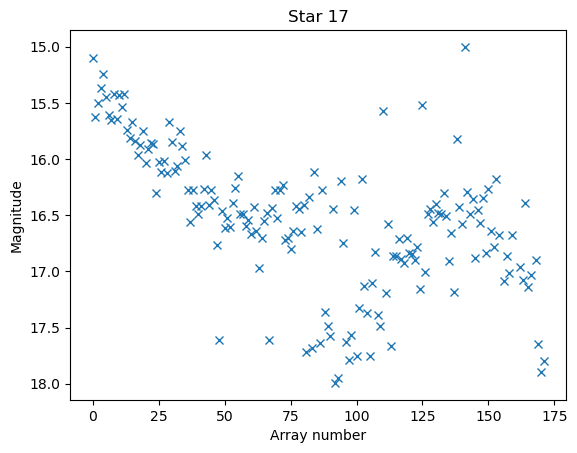

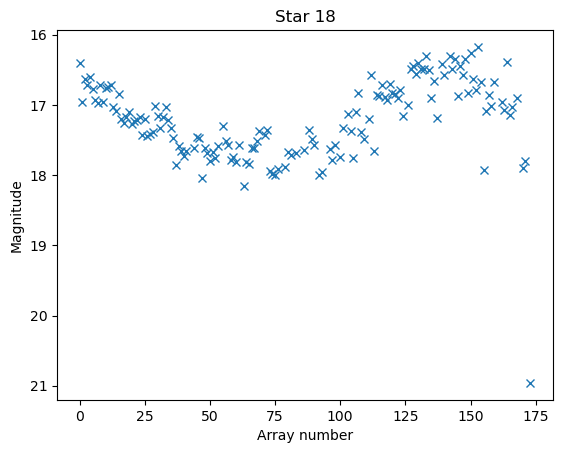

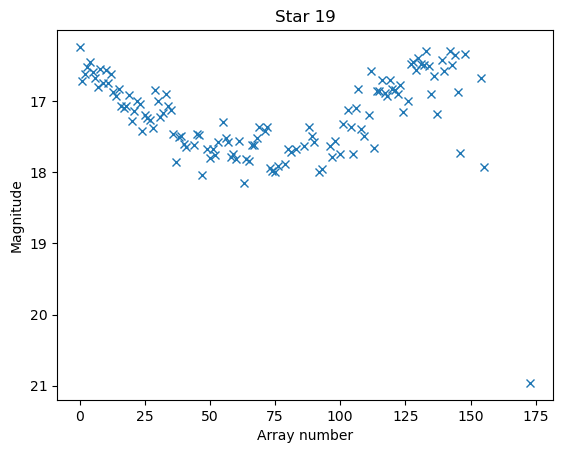

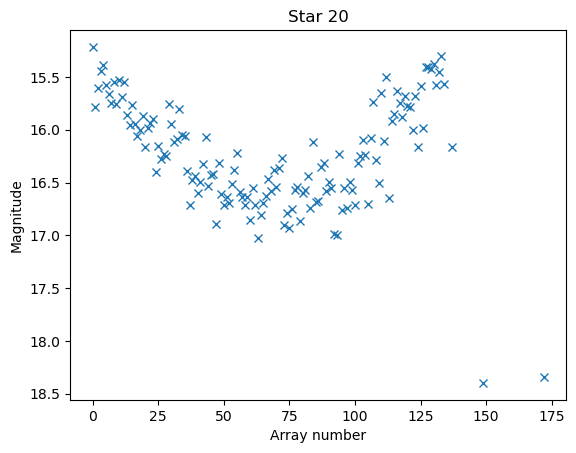

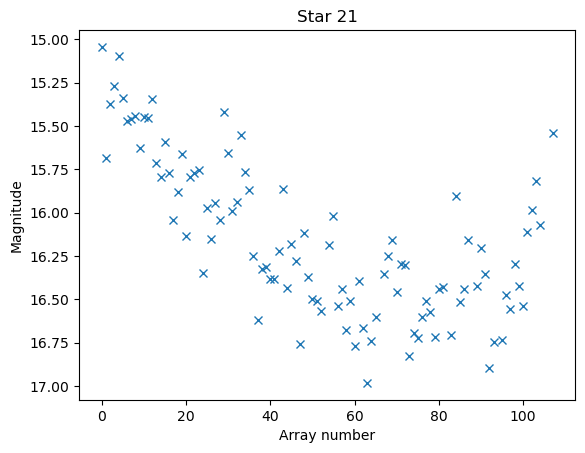

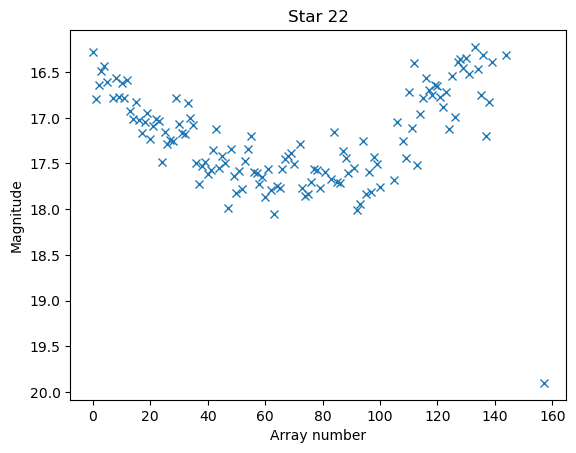

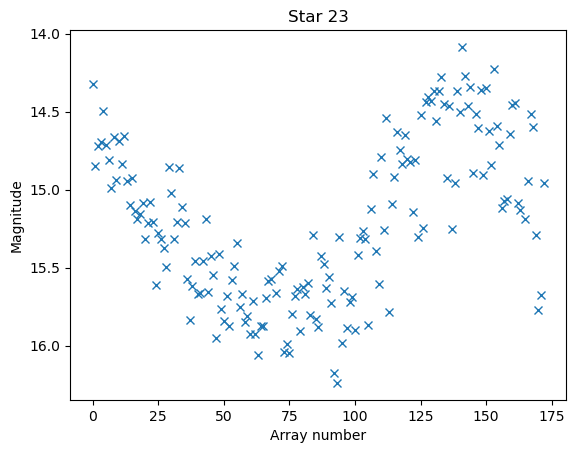

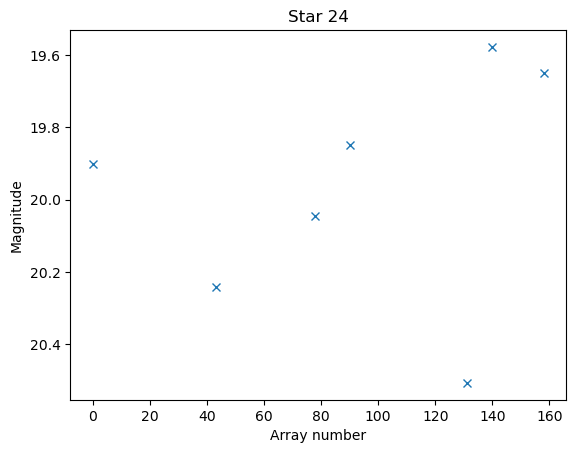

In [21]:
for index, lst in enumerate(magnitude_list_standard_stars):
    plt.plot(lst, 'x')
    plt.title(f'Star {stars_index[index]}')
    plt.xlabel('Array number')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.show()
    plt.close()

In [22]:
bad_stars_index = [0,1,3,4,8,10,11,12,15,18,19,20,22,24]

corrected_stars_index = [i for i in range(len(sources_first_array_no_duplicates)) if i not in bad_stars_index and i not in saturated_stars_and_RZ_Cep]

flux_list_standard_stars = [all_fluxes_transposed[i] for i in corrected_stars_index]
magnitude_list_standard_stars = [all_magnitudes_transposed[i] for i in corrected_stars_index]
error_list_standard_stars = [all_magnitude_error_transposed[i] for i in corrected_stars_index]

In [23]:
# Now we transpose the all_magnitudes list so that each list contains all the magnitudes of each star
all_flux_offsets_standard_stars = list()
all_magnitude_offsets_standard_stars = list()
all_magnitude_offset_errors_standard_stars = list()

for index, flux_list in enumerate(all_fluxes_transposed):
    if index in corrected_stars_index:
        offset = [flux_list[0]- i for i in flux_list]
        all_flux_offsets_standard_stars.append(offset)

for index, mag_list, error_list in zip(range(len(all_magnitudes_transposed)), all_magnitudes_transposed, all_magnitude_error_transposed):
    if index in corrected_stars_index:
        offset = [mag_list[0]- i for i in mag_list]
        offset_error = [error_list[0] + i for i in error_list]
        all_magnitude_offsets_standard_stars.append(offset)
        all_magnitude_offset_errors_standard_stars.append(offset_error)

In [24]:
mean_magnitude_offsets = np.nanmean(all_magnitude_offsets_standard_stars, axis = 0)
mean_flux_offsets = np.nanmean(all_flux_offsets_standard_stars, axis = 0)

std_magnitude_offsets = np.nanstd(all_magnitude_offsets_standard_stars, axis = 0)
std_flux_offsets = np.nanstd(all_flux_offsets_standard_stars, axis = 0)

sem_magnitude_offset = np.nanmean(all_magnitude_offset_errors_standard_stars, axis = 0)

C:\Users\cuco2\AppData\Local\Temp\ipykernel_25088\4269937871.py:1: RuntimeWarning: Mean of empty slice
  mean_magnitude_offsets = np.nanmean(all_magnitude_offsets_standard_stars, axis = 0)
C:\Users\cuco2\AppData\Local\Temp\ipykernel_25088\4269937871.py:2: RuntimeWarning: Mean of empty slice
  mean_flux_offsets = np.nanmean(all_flux_offsets_standard_stars, axis = 0)
C:\Users\cuco2\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cuco2\AppData\Local\Temp\ipykernel_25088\4269937871.py:7: RuntimeWarning: Mean of empty slice
  sem_magnitude_offset = np.nanmean(all_magnitude_offset_errors_standard_stars, axis = 0)


In [25]:
import numpy as np
corrected_RZ_Cep_flux = np.array(RZ_Cep_fluxes[0]) + mean_flux_offsets
corrected_RZ_Cep_magnitude = np.array(RZ_Cep_magnitudes[0]) + mean_magnitude_offsets
RZ_Cep_error = np.array(RZ_Cep_mag_error) + sem_magnitude_offset

# Plots

In [26]:
corrected_magnitudes = list()
corrected_magnitude_error = list()
for star in magnitude_list_standard_stars:
    corrected_magnitudes.append(np.array(star) + mean_magnitude_offsets)


for star_error in error_list_standard_stars:
    corrected_magnitude_error.append(np.array(star_error) + sem_magnitude_offset)

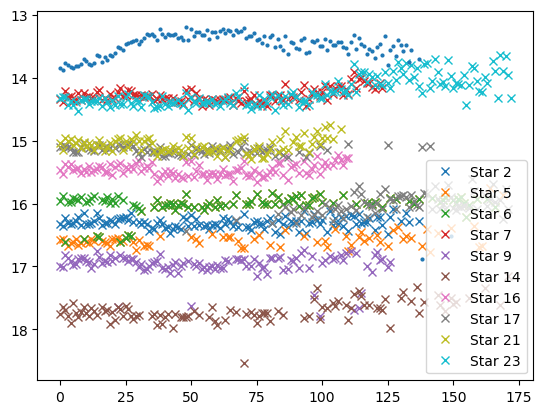

In [27]:
for index, star in enumerate(corrected_magnitudes):
    plt.plot(star, 'x', label = f'Star {corrected_stars_index[index]}')
plt.plot(corrected_RZ_Cep_magnitude, 'o', markersize = 2)
plt.legend()
plt.gca().invert_yaxis();

In [28]:
corrected_RZ_Cep_magnitude[[138, 149]] = np.nan

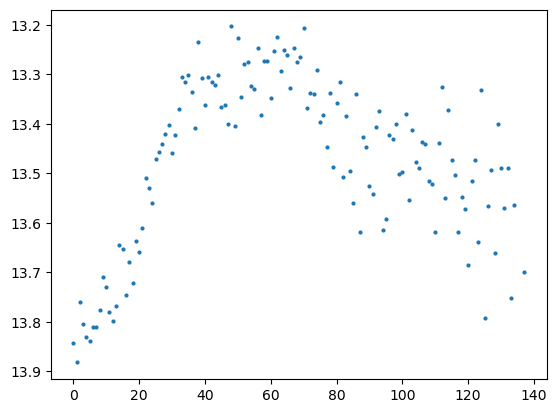

In [29]:
plt.plot(corrected_RZ_Cep_magnitude, 'o', markersize = 2)
# plt.legend()
plt.gca().invert_yaxis();

In [30]:
print('Corrected magnitudes')
print(np.mean(np.nanstd(corrected_magnitudes, axis = 1)))
print(max(np.nanstd(corrected_magnitudes, axis = 1)))
print('\n\n')
print('Corrected RV UMa')
print(np.nanmean(RZ_Cep_magnitudes[0]))
print(np.nanstd(RZ_Cep_magnitudes[0]))

Corrected magnitudes
0.18860000701006419
0.44940235904134346



Corrected RV UMa
14.553829419828062
0.473684879139577


In [31]:
print('Not corrected magnitudes')
print(np.mean(np.nanstd(magnitude_list_standard_stars, axis = 1)))
print(max(np.nanstd(magnitude_list_standard_stars, axis = 1)))
print('Not corrected RV UMa')
print(np.nanmean(corrected_RZ_Cep_magnitude))
print(np.nanstd(corrected_RZ_Cep_magnitude))

Not corrected magnitudes
0.46567240326650283
0.6282060689667215
Not corrected RV UMa
13.474263785121838
0.16870701452396972


# Plotting with time on the x-axis

In [32]:
import datetime
from astropy.time import Time

times = [datetime.datetime.strptime(header["DATE-OBS"], '%Y-%m-%dT%H:%M:%S.%f') for header in headers]
times = [Time(i).jd for i in times]
t = [time - times[0] for time in times]

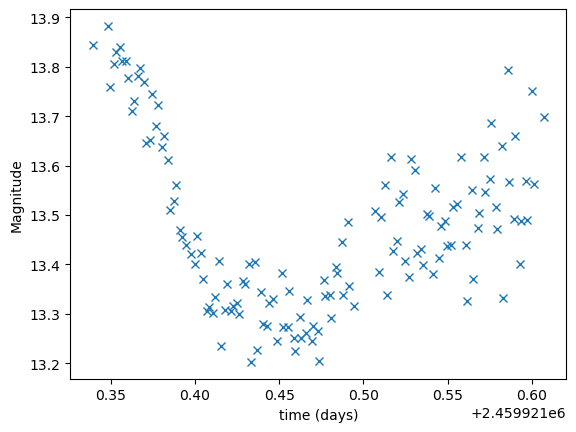

In [33]:
plt.plot(times, corrected_RZ_Cep_magnitude, 'x')
plt.xlabel('time (days)')
plt.ylabel('Magnitude');

In [34]:
period = 0.30868 # period in days
phase = np.array(t)/period - np.floor(np.array(t)/period)

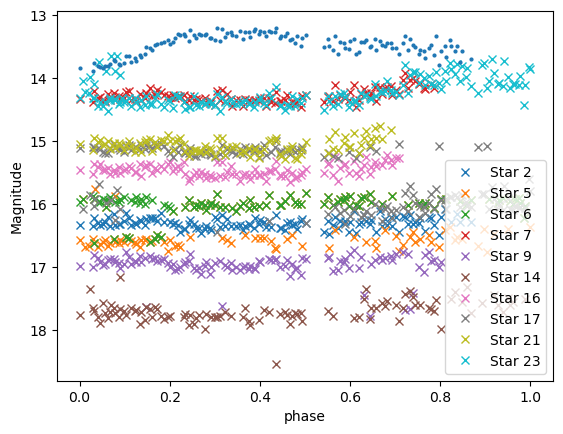

In [35]:
for index, star in enumerate(corrected_magnitudes):
    plt.plot(phase, star, 'x', label = f'Star {corrected_stars_index[index]}')
plt.plot(phase, corrected_RZ_Cep_magnitude, 'o', markersize = 2)
plt.legend()
plt.gca().invert_yaxis();
plt.xlabel('phase')
plt.ylabel('Magnitude');

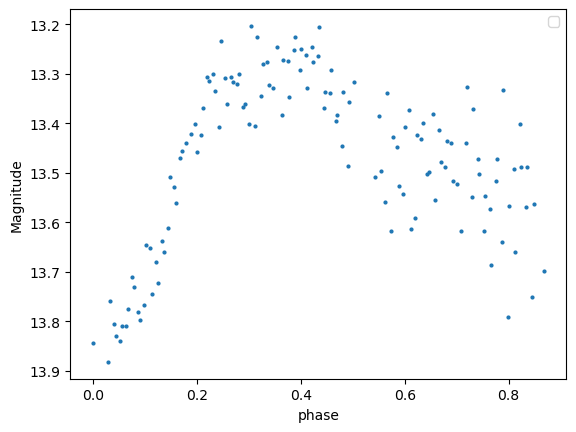

In [36]:
plt.plot(phase, corrected_RZ_Cep_magnitude, 'o', markersize = 2)
plt.legend()
plt.gca().invert_yaxis();
plt.xlabel('phase')
plt.ylabel('Magnitude');

In [37]:
# Move everything to txt file

with open(f'RZ_CepData{filter.upper()}.txt', 'w') as f:
    f.write(str(filter))
    f.write('\n\n\n***************************************************************\n\n\n')
    f.write(str(phase))
    f.write('\n\n\n***************************************************************\n\n\n')
    f.write(str(corrected_RZ_Cep_magnitude))
    f.write('\n\n\n***************************************************************\n\n\n')
    f.write(str(RZ_Cep_error))
    f.write('\n\n\n***************************************************************\n\n\n')
    f.write(str(np.array(times)))